<h1> <center><font color='green' > <b>AGN Redshift Predicetion for AGNDB</b></font> </center></h1>

# Model Building
by Sicong Huang <br> \
<font color='blue'>Python Version: 3.6.5 <br>
AGNDB Version: 1.1.0

# THE QUESTION: <br><font color='green'>How to use ML methods to predict photometric redshift for agns in AGNDB?</font>

# GOAL of the modeling
<font color='green'>Build models to predict redshift based on magnitudes

# Model Selection:
<font color='green'>__Machine learning & deep learning__:
- Multiple Linear Regression
- Random Forest
- k-Nearest Neighbour
- Neural Network

# IMPORT LIBRARIES

In [99]:
# System
import os
import glob
from tqdm import tqdm
from IPython.display import Markdown, display, Audio
import joblib

# Web Scraping

# Data Analysis
import pandas as pd
import numpy as np
from math import sqrt

# Machine Learning
from sklearn import linear_model, neighbors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Neural Network
from tensorflow import keras
from keras.layers import Input, Dense, Activation, Flatten
from keras.models import Model

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline

# Functions

In [2]:
def sound_effect(fail=0):
    """
    Play a sound when job is finished
    """
    if fail == 0:
        sound_file = '/data/home/sicong/sounds/jobs-done_1.mp3'
        display(Audio(sound_file, autoplay=True))
    else:
        sound_file = '/data/home/sicong/sounds/oh-shit-im-sorry_0001.mp3'
        display(Audio(sound_file, autoplay=True))

In [3]:
def printmd(string):
    """
    print in markdown style
    """
    display(Markdown(string))

In [4]:
def accuracy(y_true, y_pred):
    """
    calculate the accuracy based on mean absolute percentage error
    """
    # Calculate the absolute errors
    errors = abs(y_pred - y_true)

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_true)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    accuracy = str(round(accuracy, 2))+'%' 
    return accuracy 

# Data Understanding:

## Known Issues:

<ul>
  <font color='green'><li>Limited number of magnitude columns</li></font>
    <ul><li>Get more data</li></ul>    
  <font color='green'><li>Redshift error data is insufficient.</li></font>  
    <ul><li>Estimation on bias may be inaccurate</li></ul>
</ul>

## Read train/dev/test sets

In [5]:
df_train = pd.read_pickle('agnz_train.pkl')
df_dev = pd.read_pickle('agnz_dev.pkl')

In [6]:
df_train.describe()

,RA,DEC,best_z,best_z_error,i_mag,r_mag,z_mag,u_mag,g_mag,W1_mag,W2_mag,W4_mag,W3_mag
count,"70,528.00","70,528.00","70,528.00","69,707.00","70,528.00","70,528.00","70,528.00","70,528.00","70,528.00","70,528.00","70,528.00","70,528.00","70,528.00"
mean,207.63,26.53,1.73,0.00,19.98,20.08,19.86,21.01,20.27,18.92,18.54,15.36,17.01
std,76.59,19.42,0.81,0.00,1.09,1.07,1.08,1.58,1.10,1.04,1.13,0.50,0.81
min,1.25,-21.80,0.01,0.00,14.52,14.94,10.00,10.00,10.00,12.56,12.20,9.93,10.97
25%,178.71,10.38,1.06,0.00,19.16,19.33,19.08,19.92,19.52,18.25,17.78,15.12,16.55
50%,210.68,25.33,1.68,0.00,20.04,20.17,19.90,20.93,20.36,19.02,18.64,15.42,17.19
75%,237.20,43.23,2.31,0.00,20.76,20.88,20.57,21.90,21.08,19.71,19.39,15.68,17.58
max,360.00,83.92,6.97,0.26,24.73,25.00,24.63,27.50,27.50,22.36,21.38,16.79,18.85


In [7]:
df_dev.describe()

,RA,DEC,best_z,best_z_error,i_mag,r_mag,z_mag,u_mag,g_mag,W1_mag,W2_mag,W4_mag,W3_mag
count,"17,632.00","17,632.00","17,632.00","17,447.00","17,632.00","17,632.00","17,632.00","17,632.00","17,632.00","17,632.00","17,632.00","17,632.00","17,632.00"
mean,207.23,26.47,1.74,0.00,19.98,20.08,19.85,21.02,20.27,18.92,18.53,15.36,17.00
std,76.03,19.48,0.81,0.00,1.08,1.07,1.08,1.60,1.10,1.04,1.13,0.50,0.81
min,3.49,-23.17,0.06,0.00,14.70,15.13,10.00,10.00,14.09,11.26,11.93,10.04,11.18
25%,177.88,10.03,1.07,0.00,19.15,19.32,19.07,19.90,19.50,18.24,17.77,15.12,16.54
50%,209.66,25.38,1.69,0.00,20.04,20.16,19.89,20.95,20.36,19.01,18.64,15.41,17.19
75%,237.04,43.29,2.31,0.00,20.76,20.88,20.57,21.92,21.09,19.71,19.38,15.68,17.58
max,359.99,83.39,6.45,0.02,23.34,24.26,25.39,27.50,27.50,21.65,21.23,16.62,18.77


In [9]:
print(f'Training set size: {df_train.shape}')
print(f'Dev set size: {df_dev.shape}')

Training set size: (70528, 13)
Dev set size: (17632, 13)


## Convert train/dev/test dataframe to numpy array

In [6]:
#(x_train, x_dev, x_test, y_train, y_dev, y_test) = 
features = [col for col in df_train.columns if 'mag' in col]
x_train = np.array(df_train[features])
y_train = np.array(df_train['best_z'])

x_dev = np.array(df_dev[features])
y_dev = np.array(df_dev['best_z'])

In [7]:
print ("Number of training examples: m_train = " + str(x_train.shape[0]))
print ("Number of validataion examples: m_dev = " + str(x_dev.shape[0]))

print ("train_set_x shape: " + str(x_train.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("dev_set_x shape: " + str(x_dev.shape))
print ("dev_set_y shape: " + str(y_dev.shape))


Number of training examples: m_train = 70528
Number of validataion examples: m_dev = 17632
train_set_x shape: (70528, 9)
train_set_y shape: (70528,)
dev_set_x shape: (17632, 9)
dev_set_y shape: (17632,)


In [8]:
print(*features,sep='\n')

i_mag
r_mag
z_mag
u_mag
g_mag
W1_mag
W2_mag
W4_mag
W3_mag


## Normalize

In [9]:
x_train = (x_train - x_train.mean(axis=0)) / (x_train.std(axis=0))
x_dev = (x_dev - x_dev.mean(axis=0)) / (x_dev.std(axis=0))

In [10]:
# check for nan in sets
np.sum(np.isnan(x_dev))

0

# Data Modeling
<font color='green'> Use <font color='blue'>Mean absolute error </font>as evaluation metric

## Multi-variant Linear Regression

<font color='green'>Load model from file

In [41]:
joblib_file = "LR_Model.pkl"  
lr = joblib.load(joblib_file)

In [26]:
%store -r yhat_train_lr
%store -r yhat_dev_lr

<font color='green'> Build the model

In [113]:
# raise our features to a power of 2
poly = PolynomialFeatures(degree=3)
x_train_poly = poly.fit_transform(x_train)
x_dev_poly = poly.fit_transform(x_dev)

In [115]:
%%time
lr = linear_model.LinearRegression()
lr.fit(x_train_poly, y_train)
# The coefficients
#print ('Coefficients: ', lr.coef_)

CPU times: user 11.4 s, sys: 11.4 s, total: 22.8 s
Wall time: 1.1 s


LinearRegression()

In [116]:
yhat_train_lr = lr.predict(x_train_poly)
yhat_dev_lr = lr.predict(x_dev_poly) #Predicting on the test data

In [117]:
printmd("<font color='green'> Training set:")
print("Residual sum of squares: %.2f"
      % np.mean((yhat_train_lr - y_train) ** 2))

print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_train, yhat_train_lr)))
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_train, yhat_train_lr))
print('Accuracy:', accuracy(y_train, yhat_train_lr))

printmd("<font color='green'> Dev set:")
print("Residual sum of squares: %.2f"
      % np.mean((yhat_dev_lr - y_dev) ** 2))

print('Root Mean Squared Error: %.2f'% np.sqrt(mean_squared_error(y_dev, yhat_dev_lr)))
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_dev, yhat_dev_lr))
print('Accuracy:', accuracy(y_dev, yhat_dev_lr))

<font color='green'> Training set:

Residual sum of squares: 0.13
Root Mean Squared Error: 0.37
Mean Absolute Error: 0.26
Accuracy: 76.5%


<font color='green'> Dev set:

Residual sum of squares: 0.33
Root Mean Squared Error: 0.57
Mean Absolute Error: 0.27
Accuracy: 76.49%


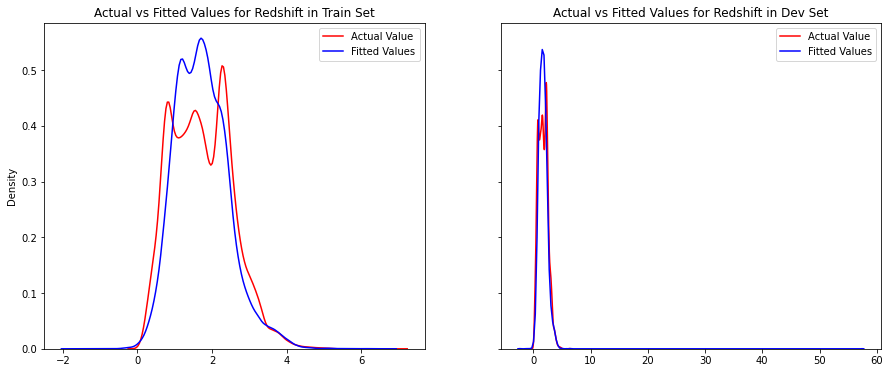

In [151]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
sns.kdeplot(x=y_train, ax=axes[0], color="r", label="Actual Value")
sns.kdeplot(x=yhat_train_lr, ax=axes[0], color="b", label="Fitted Values" )
axes[0].set_title('Actual vs Fitted Values for Redshift in Train Set')

sns.kdeplot(x=y_dev, ax=axes[1], color="r", label="Actual Value")
sns.kdeplot(x=yhat_dev_lr, ax=axes[1], color="b", label="Fitted Values")
axes[1].set_title('Actual vs Fitted Values for Redshift in Dev Set')

axes[0].legend()
axes[1].legend()
plt.show();

<font color='red'> __Conclusion__:</font>
<font color='green'>
- The performance is moderate. 
- Extreme values exist.

<font color='green'> Save model to file

In [122]:
joblib_file = "LR_Model.pkl"  
joblib.dump(lr, joblib_file)

['LR_Model.pkl']

In [123]:
%store yhat_train_lr
%store yhat_dev_lr

Stored 'yhat_train_lr' (ndarray)
Stored 'yhat_dev_lr' (ndarray)


## Random Forest 

<font color='green'> Load model from file

In [15]:
joblib_file = "RF_Model.pkl"  
Tree = joblib.load(joblib_file)

In [149]:
%store -r yhat_train_rf
%store -r yhat_dev_rf

In [11]:
%%time
# try 1000 trees
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 42, n_jobs = 5)
regressor.fit(x_train, y_train)

CPU times: user 11min 2s, sys: 3.07 s, total: 11min 5s
Wall time: 2min 14s


RandomForestRegressor(n_estimators=1000, n_jobs=5, random_state=42)

In [13]:
yhat_train_rf = regressor.predict(x_train)
yhat_dev_rf = regressor.predict(x_dev)

In [14]:
printmd("<font color='green'> Training set:")
print("Residual sum of squares: %.2f"
      % np.mean((yhat_train_rf - y_train) ** 2))

print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_train, yhat_train_rf)))
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_train, yhat_train_rf))
print('Accuracy:', accuracy(y_train, yhat_train_rf))

printmd("<font color='green'> Dev set:")
print("Residual sum of squares: %.2f"
      % np.mean((yhat_dev_rf - y_dev) ** 2))

print('Root Mean Squared Error: %.2f'% np.sqrt(mean_squared_error(y_dev, yhat_dev_rf)))
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_dev, yhat_dev_rf))
print('Accuracy:', accuracy(y_dev, yhat_dev_rf))

<font color='green'> Training set:

Residual sum of squares: 0.01
Root Mean Squared Error: 0.12
Mean Absolute Error: 0.08
Accuracy: 93.23%


<font color='green'> Dev set:

Residual sum of squares: 0.11
Root Mean Squared Error: 0.33
Mean Absolute Error: 0.21
Accuracy: 82.35%


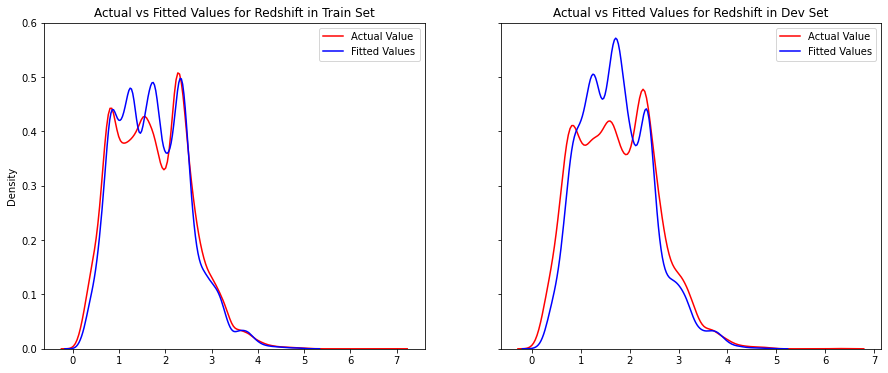

In [150]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
sns.kdeplot(x=y_train, ax=axes[0], color="r", label="Actual Value")
sns.kdeplot(x=yhat_train_rf, ax=axes[0], color="b", label="Fitted Values" )
axes[0].set_title('Actual vs Fitted Values for Redshift in Train Set')

sns.kdeplot(x=y_dev, ax=axes[1], color="r", label="Actual Value")
sns.kdeplot(x=yhat_dev_rf, ax=axes[1], color="b", label="Fitted Values")
axes[1].set_title('Actual vs Fitted Values for Redshift in Dev Set')

axes[0].legend()
axes[1].legend()
plt.show();

<font color='red'> __Conclusion__:</font>
<font color='green'>

- The best performance overall is d=4 or 5  with f1_train and f1_dev ~ 80%, indicating high bias. 

<font color='green'> Save model to file

In [31]:
joblib_file = "RF_Model.pkl"  
joblib.dump(regressor, joblib_file)

['RF_Model.pkl']

In [32]:
%store yhat_train_rf
%store yhat_dev_rf

Stored 'yhat_train_rf' (ndarray)
Stored 'yhat_dev_rf' (ndarray)


## K Nearest Neighbors

<font color='green'>Load model from file

In [64]:
joblib_file = "KNN_Model.pkl"  
knn = joblib.load(joblib_file)

In [146]:
%store -r yhat_train_knn
%store -r yhat_dev_knn

In [29]:
# find the best K
params = {'n_neighbors':list(range(1,21))}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(x_train,y_train)
model.best_params_

{'n_neighbors': 16}

In [45]:
# use the best k=16
K=16
knn = neighbors.KNeighborsRegressor(n_neighbors = K)

knn.fit(x_train, y_train)  # fit the model

KNeighborsRegressor(n_neighbors=16)

In [ ]:
#Predicting on the test data
yhat_train_knn = knn.predict(x_train)
yhat_dev_knn = knn.predict(x_dev)

In [58]:
printmd("<font color='green'> Training set:")
print("Residual sum of squares: %.2f"
      % np.mean((yhat_train_knn - y_train) ** 2))

print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_train, yhat_train_knn)))
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_train, yhat_train_knn))
print('Accuracy:', accuracy(y_train, yhat_train_knn))


printmd("<font color='green'> Dev set:")
print("Residual sum of squares: %.2f"
      % np.mean((yhat_dev_knn - y_dev) ** 2))

print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_dev, yhat_dev_knn)))
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_dev, yhat_dev_knn))
print('Accuracy:', accuracy(y_dev, yhat_dev_knn))

<font color='green'> Training set:

Residual sum of squares: 0.11
Root Mean Squared Error: 0.34
Mean Absolute Error: 0.23
Accuracy: 79.75%


<font color='green'> Dev set:

Residual sum of squares: 0.13
Root Mean Squared Error: 0.36
Mean Absolute Error: 0.25
Accuracy: 78.96%


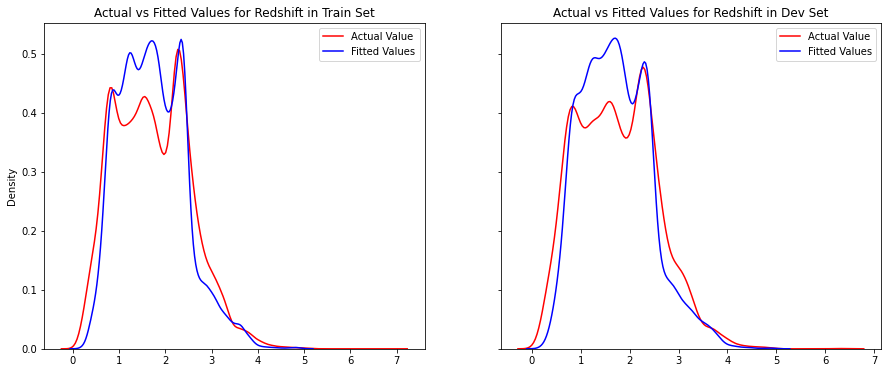

In [147]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
sns.kdeplot(x=y_train, ax=axes[0], color="r", label="Actual Value")
sns.kdeplot(x=yhat_train_knn, ax=axes[0], color="b", label="Fitted Values" )
axes[0].set_title('Actual vs Fitted Values for Redshift in Train Set')

sns.kdeplot(x=y_dev, ax=axes[1], color="r", label="Actual Value")
sns.kdeplot(x=yhat_dev_knn, ax=axes[1], color="b", label="Fitted Values")
axes[1].set_title('Actual vs Fitted Values for Redshift in Dev Set')

axes[0].legend()
axes[1].legend()
plt.show();

<font color='red'> __Conclusion__:</font>
<font color='green'>
- Better than LR.

<font color='green'> Save model to file

In [47]:
joblib_file = "KNN_Model.pkl"  
joblib.dump(knn, joblib_file)

['KNN_Model.pkl']

In [48]:
%store yhat_train_knn
%store yhat_dev_knn

Stored 'yhat_train_knn' (ndarray)
Stored 'yhat_dev_knn' (ndarray)


## Neural Network
Based on https://ui.adsabs.harvard.edu/abs/2021MNRAS.503.2639C/abstract

The structure of the network is as follows:
- Input size = (9x1)
- 200 neurons for each layer
- RMSprop
- Early stop with patience = 10
- MAE as loss function

<font color='green'> Load model from file

In [11]:
Z_NN = keras.models.load_model('agn_NN.pd')

In [12]:
%store -r yhat_train_cnn
%store -r yhat_dev_cnn

<font color='green'> Build the model

In [11]:
x_train_nn = x_train.reshape(-1,9,1,1)
x_dev_nn = x_dev.reshape(-1,9,1,1)

In [133]:
def model_NN(input_shape):
    """
    Implementation of the AGN_NN.
    
    Arguments:
    input_shape -- shape of the input of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    

    Returns:
    model -- a Model() instance in Keras
    """
  # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    
    X_input = Input(input_shape)
    
    X = Flatten()(X_input)
    X = Dense(200, activation='relu', name='l0')(X)
    X = Dense(200, activation='relu', name='l1')(X)
    X = Dense(200, activation='tanh', name='l2')(X)    
    X = Dense(1, activation='linear')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='Z_NN')

    
    ### END CODE HERE ###
    
    return model

In [134]:
# early stop with patience = 10
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [135]:
Z_NN = model_NN(x_train_nn.shape[1:])

# compile the model
Z_NN.compile(optimizer='rmsprop', loss="mean_absolute_error")

In [136]:
Z_NN.summary()

Model: "Z_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 9, 1, 1)]         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9)                 0         
_________________________________________________________________
l0 (Dense)                   (None, 200)               2000      
_________________________________________________________________
l1 (Dense)                   (None, 200)               40200     
_________________________________________________________________
l2 (Dense)                   (None, 200)               40200     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total params: 82,601
Trainable params: 82,601
Non-trainable params: 0
__________________________________________________________

In [137]:
# Train the model
history = Z_NN.fit(
            x_train_nn,
            y_train,
            batch_size=512,
            callbacks=[callback],
            epochs=200,
            verbose=1,
            validation_data=(x_dev_nn, y_dev))

Epoch 1/200
138/138 [==============================] - 1s 6ms/step - loss: 0.5397 - val_loss: 0.3705
Epoch 2/200
138/138 [==============================] - 1s 4ms/step - loss: 0.3162 - val_loss: 0.3039
Epoch 3/200
138/138 [==============================] - 1s 4ms/step - loss: 0.2715 - val_loss: 0.2645
Epoch 4/200
138/138 [==============================] - 1s 5ms/step - loss: 0.2534 - val_loss: 0.2467
Epoch 5/200
138/138 [==============================] - 1s 5ms/step - loss: 0.2387 - val_loss: 0.2198
Epoch 6/200
138/138 [==============================] - 1s 5ms/step - loss: 0.2274 - val_loss: 0.2183
Epoch 7/200
138/138 [==============================] - 1s 4ms/step - loss: 0.2178 - val_loss: 0.2128
Epoch 8/200
138/138 [==============================] - 1s 5ms/step - loss: 0.2095 - val_loss: 0.2110
Epoch 9/200
138/138 [==============================] - 1s 5ms/step - loss: 0.2048 - val_loss: 0.1969
Epoch 10/200
138/138 [==============================] - 1s 5ms/step - loss: 0.1991 - val_lo

In [138]:
yhat_train_nn = Z_NN.predict(x_train_nn, batch_size=512, verbose=1)
yhat_train_nn = yhat_train_nn.reshape(yhat_train_nn.shape[0],)
yhat_dev_nn = Z_NN.predict(x_dev_nn, batch_size=512, verbose=1)
yhat_dev_nn = yhat_dev_nn.reshape(yhat_dev_nn.shape[0],)

35/35 [==============================] - 0s 2ms/step


In [139]:
printmd("<font color='green'> Training set:")
print("Residual sum of squares: %.2f"
      % np.mean((yhat_train_nn - y_train) ** 2))

print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_train, yhat_train_nn)))
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_train, yhat_train_nn))
print('Accuracy:', accuracy(y_train, yhat_train_nn))


printmd("<font color='green'> Dev set:")
print("Residual sum of squares: %.2f"
      % np.mean((yhat_dev_nn - y_dev) ** 2))

print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_dev, yhat_dev_nn)))
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_dev, yhat_dev_nn))
print('Accuracy:', accuracy(y_dev, yhat_dev_nn))

<font color='green'> Training set:

Residual sum of squares: 0.08
Root Mean Squared Error: 0.29
Mean Absolute Error: 0.16
Accuracy: 86.73%


<font color='green'> Dev set:

Residual sum of squares: 0.10
Root Mean Squared Error: 0.31
Mean Absolute Error: 0.17
Accuracy: 86.05%


<font color='green'> Plot

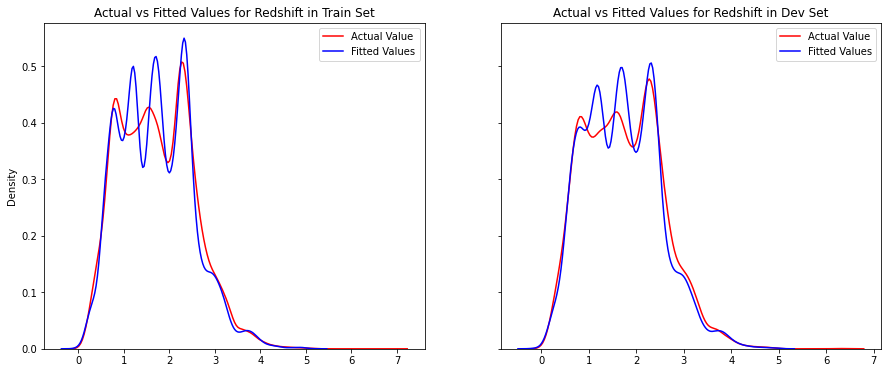

In [144]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
sns.kdeplot(x=y_train, ax=axes[0], color="r", label="Actual Value")
sns.kdeplot(x=yhat_train_nn, ax=axes[0], color="b", label="Fitted Values" )
axes[0].set_title('Actual vs Fitted Values for Redshift in Train Set')

sns.kdeplot(x=y_dev, ax=axes[1], color="r", label="Actual Value")
sns.kdeplot(x=yhat_dev_nn, ax=axes[1], color="b", label="Fitted Values")
axes[1].set_title('Actual vs Fitted Values for Redshift in Dev Set')

axes[0].legend()
axes[1].legend()
plt.show();

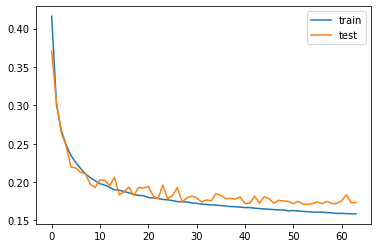

In [141]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<font color='green'> Early stopping
see https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

<font color='green'>Save model to file

In [142]:
Z_NN.save('Z_NN.pd')

INFO:tensorflow:Assets written to: Z_NN.pd/assets


In [143]:
%store yhat_train_nn
%store yhat_dev_nn

Stored 'yhat_train_nn' (ndarray)
Stored 'yhat_dev_nn' (ndarray)
